In [5]:
import hist
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import pandas as pd
import numpy as np
import pyarrow.feather as feather
from bff_processor.plotting_utils import color_fader
import re

In [6]:
hep.style.use(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})

In [7]:
era = '2016'
if era=='2016':
    lumistr=35.50
if era=='2017':
    lumistr=41.85
if era=='2018':
    lumistr=58.88

In [8]:
name_dict = {
'BFFZprimeToMuMu_M_125_dbs0p04': r'125 $\delta_{bs}$ 0.04', 
'BFFZprimeToMuMu_M_150_dbs0p04': r'150 $\delta_{bs}$ 0.04',
'BFFZprimeToMuMu_M_175_dbs0p04': r'175 $\delta_{bs}$ 0.04', 
'BFFZprimeToMuMu_M_200_dbs0p04': r'200 $\delta_{bs}$ 0.04',
'BFFZprimeToMuMu_M_200_dbs0p5': r'200 $\delta_{bs}$ 0.5', 
'BFFZprimeToMuMu_M_200_dbs1p0': r'200 $\delta_{bs}$ 1.0',
'BFFZprimeToMuMu_M_350_dbs0p04': r'350 $\delta_{bs}$ 0.04', 
'BFFZprimeToMuMu_M_350_dbs0p5': r'350 $\delta_{bs}$ 0.5',
'BFFZprimeToMuMu_M_350_dbs1p0': r'350 $\delta_{bs}$ 1.0', 
'BFFZprimeToMuMu_M_500_dbs0p04': r'500 $\delta_{bs}$ 0.04',
'BFFZprimeToMuMu_M_500_dbs0p5': r'500 $\delta_{bs}$ 0.5', 
'BFFZprimeToMuMu_M_500_dbs1p0': r'500 $\delta_{bs}$ 1.0',
'ZToEE_M_120_200': 'DY', 
'ZToEE_M_200_400': 'DY', 
'ZToEE_M_400_800': 'DY',
'ZToEE_M_50_120': 'DY', 
'ZToEE_M_800_1400': 'DY', 
'ZToMuMu_M_120_200': 'DY',
'ZToMuMu_M_200_400': 'DY', 
'ZToMuMu_M_400_800': 'DY', 
'ZToMuMu_M_50_120': 'DY',
'ZToMuMu_M_800_1400': 'DY', 
'data_el': 'data', 
'data_mu': 'data', 
'mc_santitop': 'ST',
'mc_stop': 'ST', 
'mc_ttbar': 'TT', 
'mc_wz': 'DB', 
'mc_zz': 'DB',
'mc_ww': 'DB'
}
def make_labels(df):
    names = df.name.to_numpy()
    for name, label in name_dict.items():
        names[names==name] = label
    return names

In [9]:
reg_keys = {'SR[0-9]':([0,0], r'$SR_b^{\mu\mu}$'),
    'CR[0-9]0':([1,0], r'$CR_j^{\mu\mu}$'),
    'CR[0-9]3':([0,1], r'$CR_b^{ee}$'),
    'CR[0-9]4':([1,1], r'$CR_j^{ee}$')}

In [10]:
df = feather.read_feather('data/combined_{}.feather'.format(era))
#df = feather.read_feather('data/combined_scaled_{}.feather'.format(era))
print(df.shape)
df = df[df.deltaR > 0.4]
print(df.shape)

(1602844, 106)
(1602844, 106)


In [11]:
def get_sys(df, reg ):  
    def regvar(region, variation): return "{}_{}".format(region, variation)
    sys_dict = {}
    sys_dict[reg] =  df[df[regvar(reg,'nom')] == 1].Weight.sum()
    for jetcorr in ['jer', 'jesTotal']:
        corr_list = []
        for direction in ['Up','Down']:
            corr = '{}{}'.format(jetcorr, direction)
            reg_temp = regvar(reg,corr)
            corr_list.append(df[df[reg_temp] == 1].Weight.sum() - sys_dict[reg])
        sys_dict[jetcorr] =  {"Up":corr_list[0], "Down":corr_list[1]}

    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        corr_list = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            corr_list.append(df[df[regvar(reg,'nom')] == 1][weightnamesys].sum() - sys_dict[reg])
        sys_dict[sys] =  {"Up":corr_list[0], "Down":corr_list[1]}
    return  pd.DataFrame(sys_dict).T
            

In [12]:
df_150 = get_sys(df[df.name=='BFFZprimeToMuMu_M_150_dbs0p04'], 'SR1')
df_175 = get_sys(df[df.name=='BFFZprimeToMuMu_M_175_dbs0p04'], 'SR1')
df_200 = get_sys(df[df.name=='BFFZprimeToMuMu_M_200_dbs0p04'], 'SR1')
df_350 = get_sys(df[df.name=='BFFZprimeToMuMu_M_350_dbs0p04'], 'SR1')

In [13]:
sys_per_df = pd.DataFrame()

In [14]:
def return_means(df):
    means = df.abs().mean(axis=1)
    return means/means[0]*100

In [15]:
sys_per_df['150'] = return_means(df_150)
sys_per_df['175'] = return_means(df_175)
sys_per_df['200'] = return_means(df_200)
sys_per_df['350'] = return_means(df_350)
print(sys_per_df.round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     150 &     175 &     200 &     350 \\
\midrule
SR1                &  100.00 &  100.00 &  100.00 &  100.00 \\
jer                &    0.30 &    0.46 &    0.49 &    0.83 \\
jesTotal           &    0.69 &    0.48 &    0.59 &    0.19 \\
Weight\_Pu          &    0.88 &    0.94 &    1.08 &    1.15 \\
Weight\_BTag        &    2.69 &    2.59 &    2.53 &    2.39 \\
Weight\_PUID        &    1.03 &    0.77 &    0.88 &    0.68 \\
Weight\_PDF\_ISRFSR\_ &   26.96 &   25.41 &   17.84 &   12.91 \\
Weight\_MuonSF      &    4.99 &    5.08 &    5.19 &    5.96 \\
Weight\_ElectronSF  &    0.00 &    0.00 &    0.00 &    0.00 \\
\bottomrule
\end{tabular}



In [16]:
df['labels'] = make_labels(df)

In [17]:
def make_hist(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              typename,
              variablename,
              uniquelabels=[]
             ):

    ldf = df[(df[regionname]==1) & (df.type==typename)]
    values = ldf[variablename]
    weights = ldf[weightname]
    labels = ldf['labels']
    if uniquelabels==[]:
        uniquelabels =  np.unique(labels)
    
    dr_hist = (hist.Hist.new
               .StrCat(uniquelabels, name = "labels")
               .Reg(*axismeta, name=axisname)
               .Weight())
    
    dr_hist.fill(labels, values, weight=weights)
    return dr_hist

In [18]:
def make_type_hists(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              variablename,
              data = 1
             ):
    uniquelabels = ['DiBoson', 'ST', 'TT', 'DY']
    typename = 'bck'
    bck_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                         variablename,
                         uniquelabels=uniquelabels)
    
    typename = 'sig'
    sig_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                        variablename,)
    
    if data:
        typename = 'data'
        data_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                             variablename,)
        return bck_hist, sig_hist, data_hist
    else:
        return bck_hist, sig_hist

In [19]:
def make_sys(df,  axismeta, axisname, regiontemplate, weightname, bck_hist, sig_hist, variablename,
            regionname):  
    sys_array = []
    sig_sys_array = []
    for jetcorr in ['jer', 'jesTotal']:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            correction = '{}{}'.format(jetcorr, direction)
            regionnamesys = regiontemplate.format(correction)
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightname, regionnamesys, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)
        
    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightnamesys, regionname, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)

    down, up = np.sum(sys_array,axis=0)
    sig_down, sig_up = np.sum(sig_sys_array, axis=0)
    return down, up, sig_down, sig_up

In [20]:

def make_stack_plot(reg, ax, rax, lumistr, era, axismeta, axisname, variablename, fontsize=10):
    #make plots
    weightname = 'Weight'
    regiontemplate = '{}_{{}}'.format(reg)
    regionname = regiontemplate.format('nom')
    bck_hist, sig_hist, data_hist = make_type_hists( df,  axismeta, axisname,  weightname, 
                                                    regionname, 
                                                    variablename
                                                   )

    # calc sys variations for mc
    down, up, sig_down, sig_up = make_sys(df,  axismeta, axisname, 
                                          regiontemplate, weightname,
                                          bck_hist, sig_hist,
                                         variablename,
                                         regionname)
    
    ####draw plots

    # Here is an example of setting up a color cycler to color the various fill patches
    # We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
    
    colors=['#ccffcc','#ffccff','#ffff99','#99ffff']
    bck_hist.plot1d(
        ax=ax,
        overlay = "labels",
        histtype="fill",
        stack=True,
        alpha=.9,
        edgecolor=(0, 0, 0, 0.3),
        color=colors
    )
    
    mc_total = bck_hist[::sum,:].values()
    stat_unc = bck_hist[::sum,:].variances()**.5
    ax.stairs(
        edges=bck_hist.axes[1].edges,
        baseline=mc_total + down - stat_unc,
        values=mc_total + up + stat_unc,
        hatch="///",
        label="Stat. + Sys. unc.",
        facecolor="none",
        linewidth=0,
        color="black",
    )
    if not 'SR' in reg: 
        data_hist.plot1d(
            ax=ax, 
            overlay="labels", 
            color='black',
            linestyle='none',
            histtype="errorbar"
        )
    
    
    # plot signals
    c1='#ff2f00'
    c2='#0486ff' #gr
    nsig = sig_hist.axes[0].size
    for i, (_down, _up) in enumerate(zip(sig_down, sig_up)):
        c = color_fader(c1,c2,mix=(i+.0)/nsig)
        label = sig_hist.axes[0].value(i)
        
        baseline = sig_hist[i,:].values() + _down - sig_hist[i,:].variances()**.5
        values =  sig_hist[i,:].values() + _up + sig_hist[i,:].variances()**.5
        
        if '0.04' in label:
            sig_hist[i,:].plot1d(ax=ax,color=c,label=label, yerr=values*0)
        else:
            sig_hist[i,:].plot1d(ax=ax,color=c, yerr=values*0)
        

        ax.stairs(
            edges=bck_hist.axes[1].edges,
            baseline = baseline,
            values= values,
            facecolor=c,
            linewidth=0,
            color=c,
            alpha=.25,
            fill=True
        )
    
    ax.set_yscale('log')
    ax.set_ylim(bottom=1e-2, top=1e5)
    leg_title = ''
    for regstr, (_,title) in reg_keys.items():
        if len(re.findall(regstr,reg))>0:
            leg_title = title 
    ax.legend(ncol=2, title=leg_title, fontsize=fontsize)
    ax.set_ylabel('Count per 5 GeV')
    
    # now draw a ratio plot
    from hist.intervals import ratio_uncertainty
    if not 'SR' in reg: 
        rax.errorbar(
                data_hist.axes[1].centers,
                data_hist[::sum,:].values()/mc_total,
                yerr = data_hist[::sum,:].variances()**.5/mc_total,
                linestyle='None',
                marker='o',
                color='k'
        )
    
    #sorts values to preserve correct order
    baseline = (down - stat_unc)/mc_total+1
    values = (up + stat_unc)/mc_total+1
    comb = np.array([baseline, values]).T
    comb.sort(axis=1)
    (baseline,values) = comb.T
    rax.stairs(
        edges=bck_hist.axes[1].edges,
        baseline=baseline,
        values=values,
        hatch="///",
        facecolor="none",
        linewidth=0,
        color="black",
    )
    
    rax.axhline(y=.5, linestyle=":", color="gray")
    rax.axhline(y=1.0, linestyle="dashed", color="gray")
    rax.axhline(y=1.5, linestyle=":", color="gray")
    rax.set_xlabel(axisname)
    rax.set_ylabel("Ratio", loc="center")
    rax.set_ylim(0, 2)
    #rax.set_xlabel("Lepton $p_{T}$ [GeV]")
    
    # add some labels
    lumi = hep.cms.label(ax=ax, lumi=lumistr,year=era);

In [21]:
axismeta = [139,110,800]
axisname = '$m_{\ell\ell}$ [GeV]'
variablename = 'DiLepMass'

In [22]:
#axismeta = [100,0,5]
#axisname = '$\delta_{R}$'
#variablename = 'deltaR'

/tmp/ipykernel_1470939/495014699.py:106: RuntimeWarning: invalid value encountered in true_divide
  baseline = (down - stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:107: RuntimeWarning: invalid value encountered in true_divide
  values = (up + stat_unc)/mc_total+1


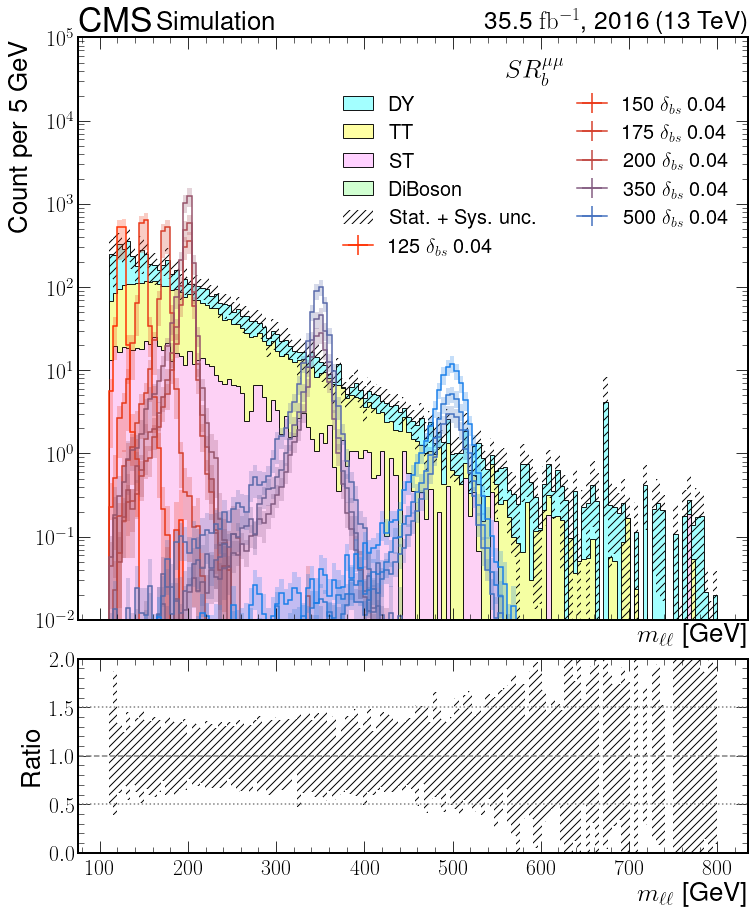

In [23]:
regions = ['SR1', 'CR10', 'CR13', 'CR14', 
 'SR2', 'CR20', 'CR23', 'CR24'] 
for region in regions:
    # define a ratio plot figure
    fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=.1),
                                  sharex=True, figsize=[12,15])
    make_stack_plot(region, ax, rax, lumistr, era, 
                    axismeta, axisname, variablename, fontsize=20)
    fig.savefig('stack_plots/{}/{}_{}_dr.png'.format(era, variablename, region))
    break

In [24]:
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom
def plot_reg(nJets, verbose=False):
    fig, axes = nratio_plot_template(nPlots=[2,2],rps = 2, figsize=[20,20])
    reg_keys = {'SR{}_{}':([0,0], r'$SR_b^{\mu\mu}$'),
    'CR{}0_{}':([1,0], r'$CR_j^{\mu\mu}$'),
    'CR{}3_{}':([0,1], r'$CR_b^{ee}$'),
    'CR{}4_{}':([1,1], r'$CR_j^{ee}$')}
    for name, ((i,j), region_text) in reg_keys.items():
        name = name.format(nJets, 'nom')
        reg = name.replace('_nom', '')
        print(name)
        
        top, bottom = axes[i][j]
        label='{} {} Jet'.format(region_text,nJets)
        make_stack_plot(reg, top, bottom, lumistr, era,
                        axismeta, axisname, variablename, fontsize=18)
        
        
    return fig

[]
SR1_nom


/tmp/ipykernel_1470939/495014699.py:106: RuntimeWarning: invalid value encountered in true_divide
  baseline = (down - stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:107: RuntimeWarning: invalid value encountered in true_divide
  values = (up + stat_unc)/mc_total+1


CR10_nom
CR13_nom


/tmp/ipykernel_1470939/495014699.py:98: RuntimeWarning: divide by zero encountered in true_divide
  data_hist[::sum,:].values()/mc_total,
/tmp/ipykernel_1470939/495014699.py:98: RuntimeWarning: invalid value encountered in true_divide
  data_hist[::sum,:].values()/mc_total,
/tmp/ipykernel_1470939/495014699.py:99: RuntimeWarning: divide by zero encountered in true_divide
  yerr = data_hist[::sum,:].variances()**.5/mc_total,
/tmp/ipykernel_1470939/495014699.py:99: RuntimeWarning: invalid value encountered in true_divide
  yerr = data_hist[::sum,:].variances()**.5/mc_total,
/home/ryan/Develop/Physics/env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3455: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]
/tmp/ipykernel_1470939/495014699.py:106: RuntimeWarning: invalid value encountered in true_divide
  baseline = (down - stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:107: RuntimeWarning: invalid v

CR14_nom


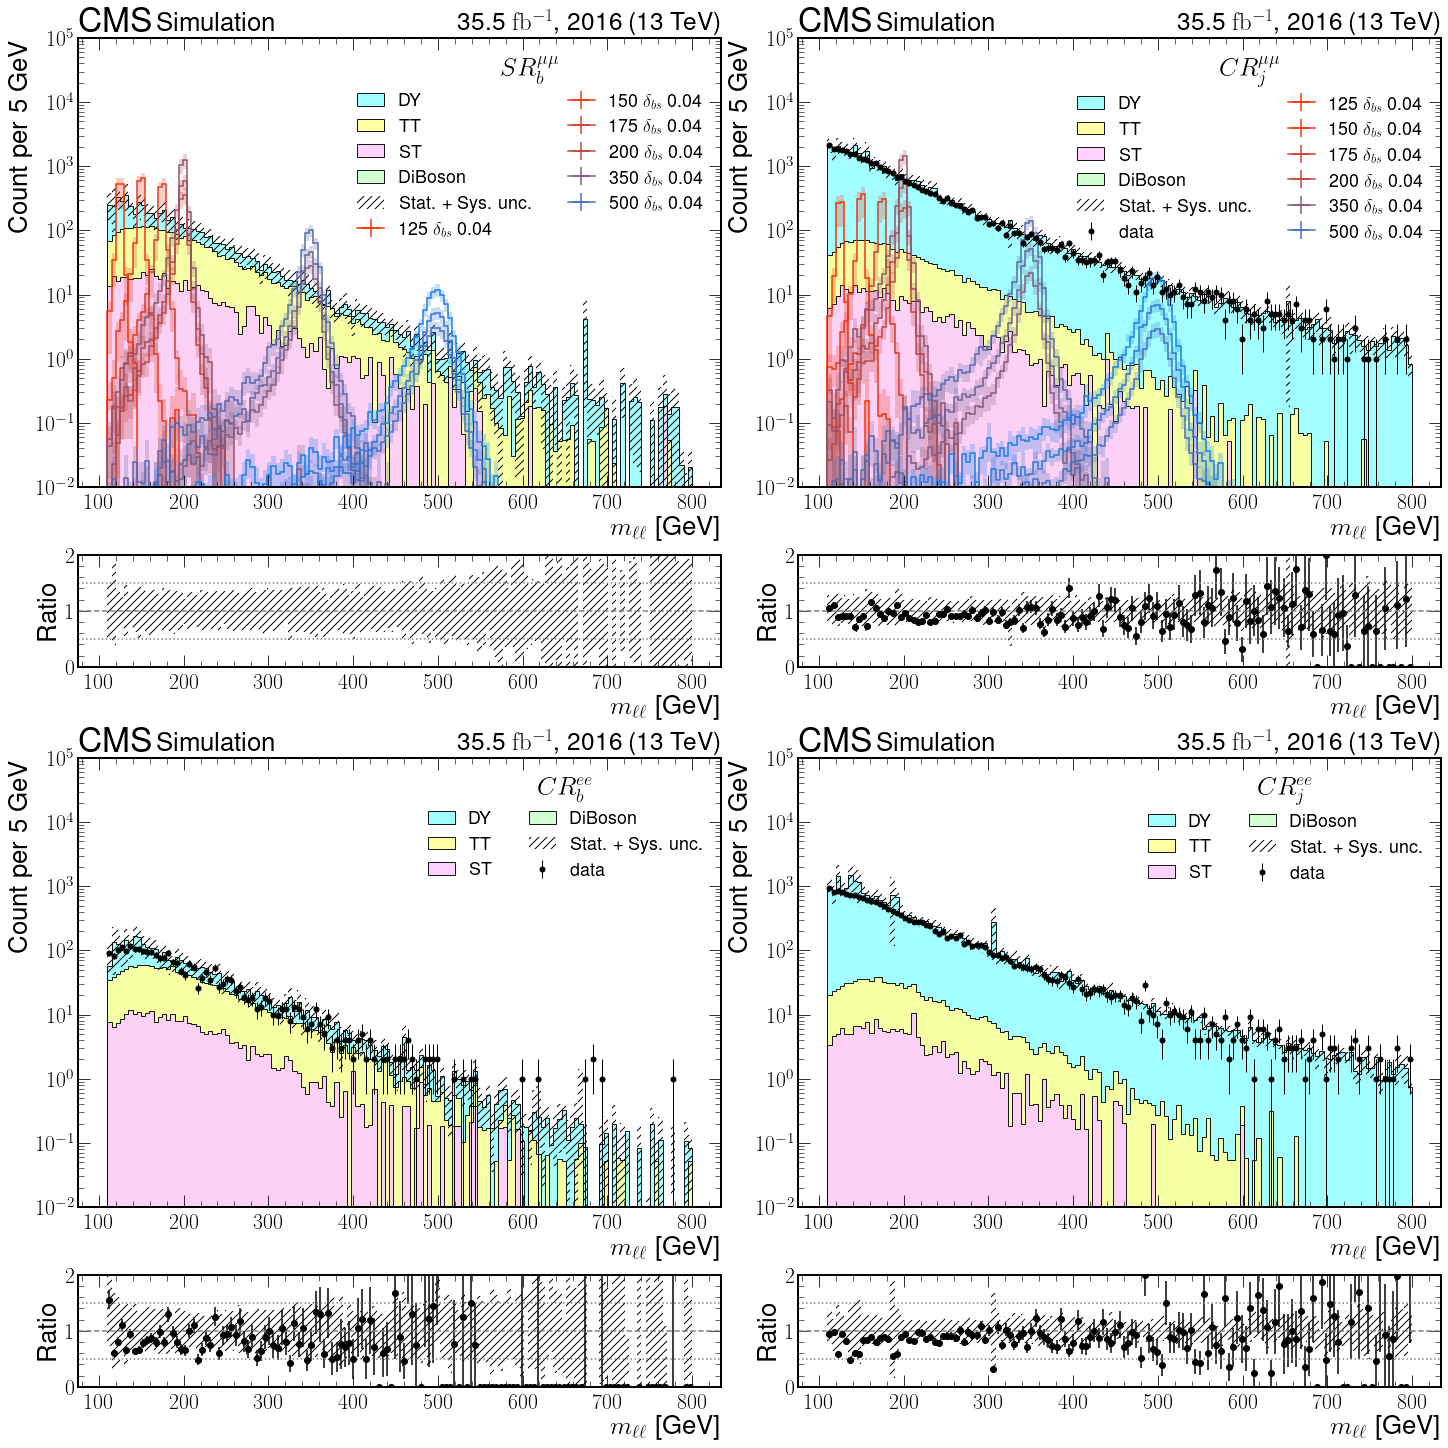

In [25]:
fig = plot_reg(1, verbose=False)
fig.savefig('stack_plots/{}/{}_nJets_{}.png'.format(era, variablename, 1))

[]
SR2_nom


/tmp/ipykernel_1470939/495014699.py:106: RuntimeWarning: divide by zero encountered in true_divide
  baseline = (down - stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:106: RuntimeWarning: invalid value encountered in true_divide
  baseline = (down - stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:107: RuntimeWarning: invalid value encountered in true_divide
  values = (up + stat_unc)/mc_total+1


CR20_nom
CR23_nom


/tmp/ipykernel_1470939/495014699.py:98: RuntimeWarning: invalid value encountered in true_divide
  data_hist[::sum,:].values()/mc_total,
/tmp/ipykernel_1470939/495014699.py:99: RuntimeWarning: invalid value encountered in true_divide
  yerr = data_hist[::sum,:].variances()**.5/mc_total,
/tmp/ipykernel_1470939/495014699.py:106: RuntimeWarning: divide by zero encountered in true_divide
  baseline = (down - stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:106: RuntimeWarning: invalid value encountered in true_divide
  baseline = (down - stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:107: RuntimeWarning: divide by zero encountered in true_divide
  values = (up + stat_unc)/mc_total+1
/tmp/ipykernel_1470939/495014699.py:107: RuntimeWarning: invalid value encountered in true_divide
  values = (up + stat_unc)/mc_total+1


CR24_nom


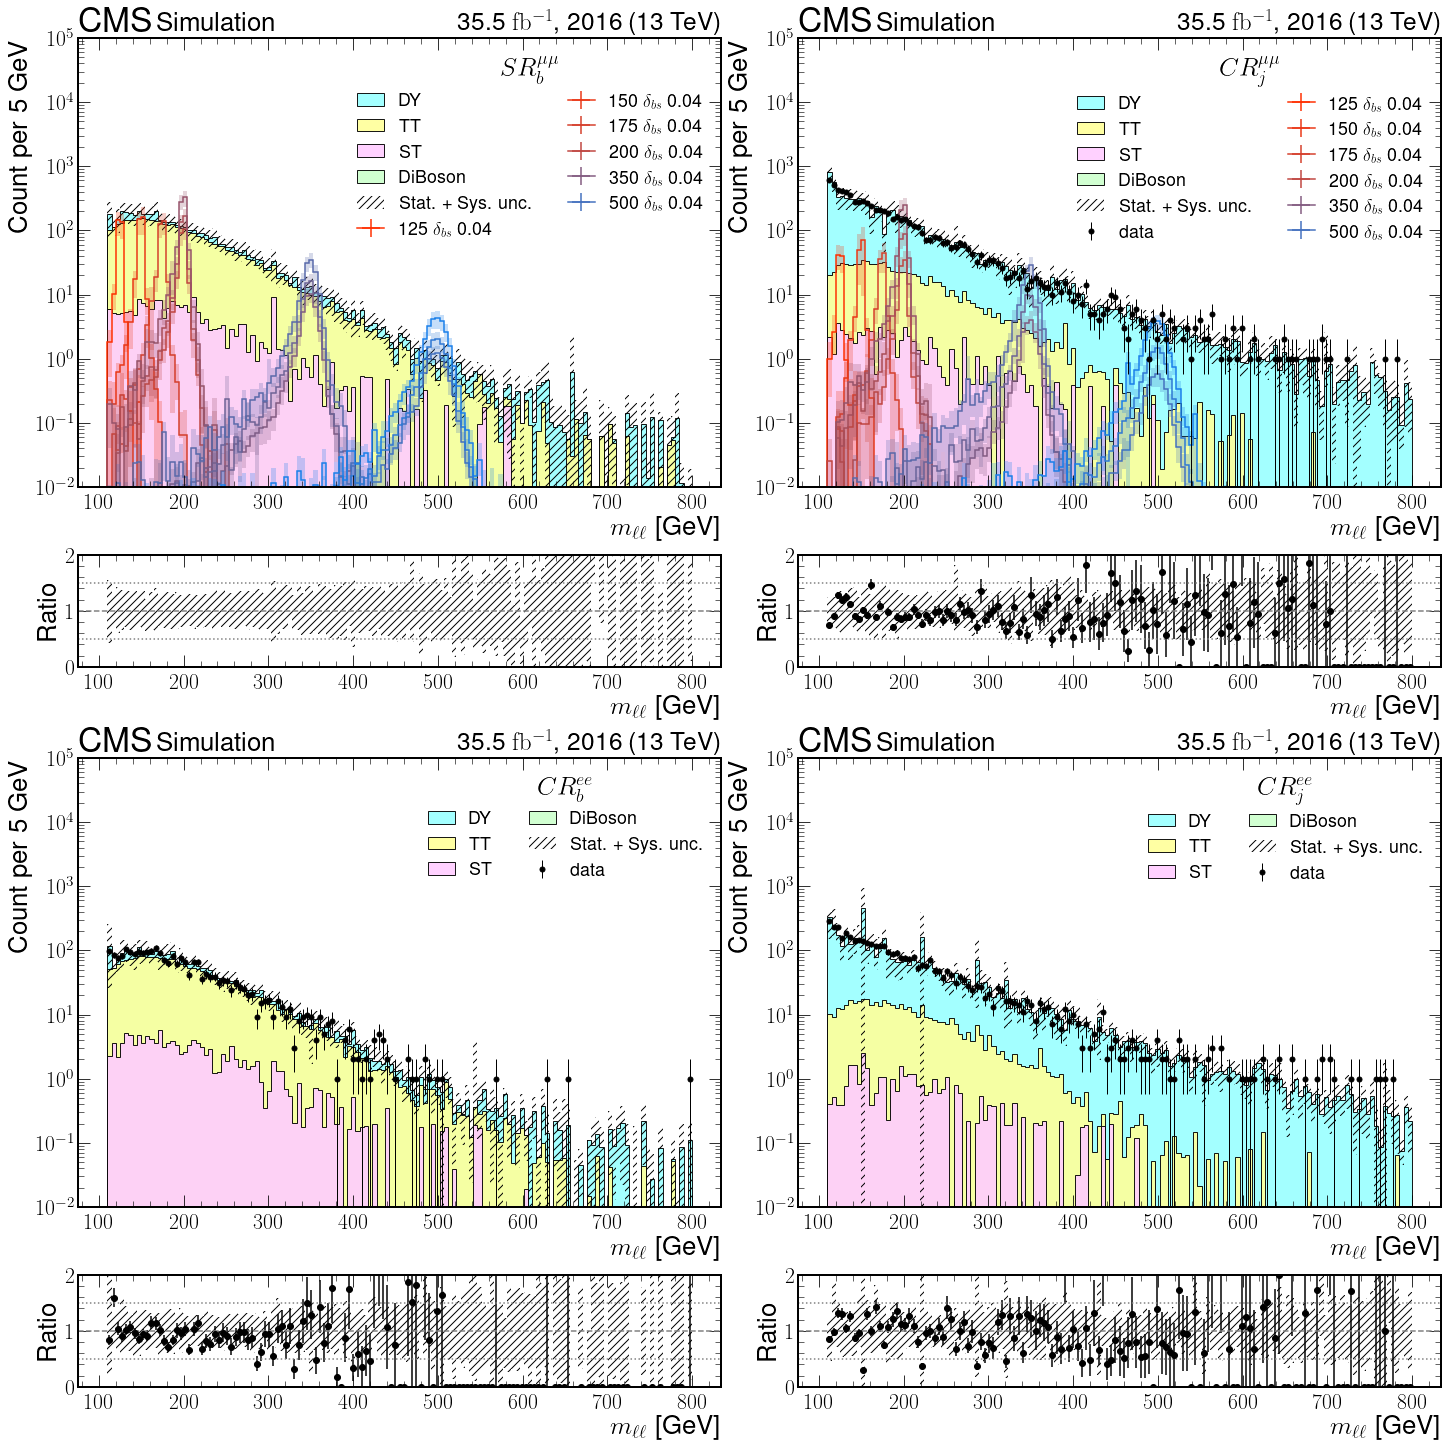

In [26]:
fig = plot_reg(2, verbose=False)
fig.savefig('stack_plots/{}/{}_nJets_{}.png'.format(era, variablename, 2));

In [28]:

def make_sys_plots(reg, ax, rax, lumistr, era, axismeta, axisname, variablename, fontsize=10):
    #make plots
    weightname = 'Weight'
    regiontemplate = '{}_{{}}'.format(reg)
    regionname = regiontemplate.format('nom')

    # calc sys variations for mc
    down, up, sig_down, sig_up = make_sys(df,  axismeta, axisname, 
                                          regiontemplate, weightname,
                                          bck_hist, sig_hist,
                                         variablename,
                                         regionname)
    

In [29]:
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom
def plot_sys(nJets, verbose=False):
    fig, axes = nratio_plot_template(nPlots=[2,2],rps = 2, figsize=[20,20])
    reg_keys = {'SR{}_{}':([0,0], r'$SR_b^{\mu\mu}$')}
    for name, ((i,j), region_text) in reg_keys.items():
        name = name.format(nJets, 'nom')
        reg = name.replace('_nom', '')
        print(name)
        bck_hist, sig_hist, data_hist = make_type_hists( df,  axismeta, axisname,  weightname, 
                                                regionname, 
                                                variablename
                                                )
        top, bottom = axes[i][j]
        label='{} {} Jet'.format(region_text,nJets)
        make_sys_plots(reg, top, bottom, lumistr, era,
                        axismeta, axisname, variablename, fontsize=18)
        
        
    return fig

[]
SR1_nom


NameError: name 'bck_hist' is not defined

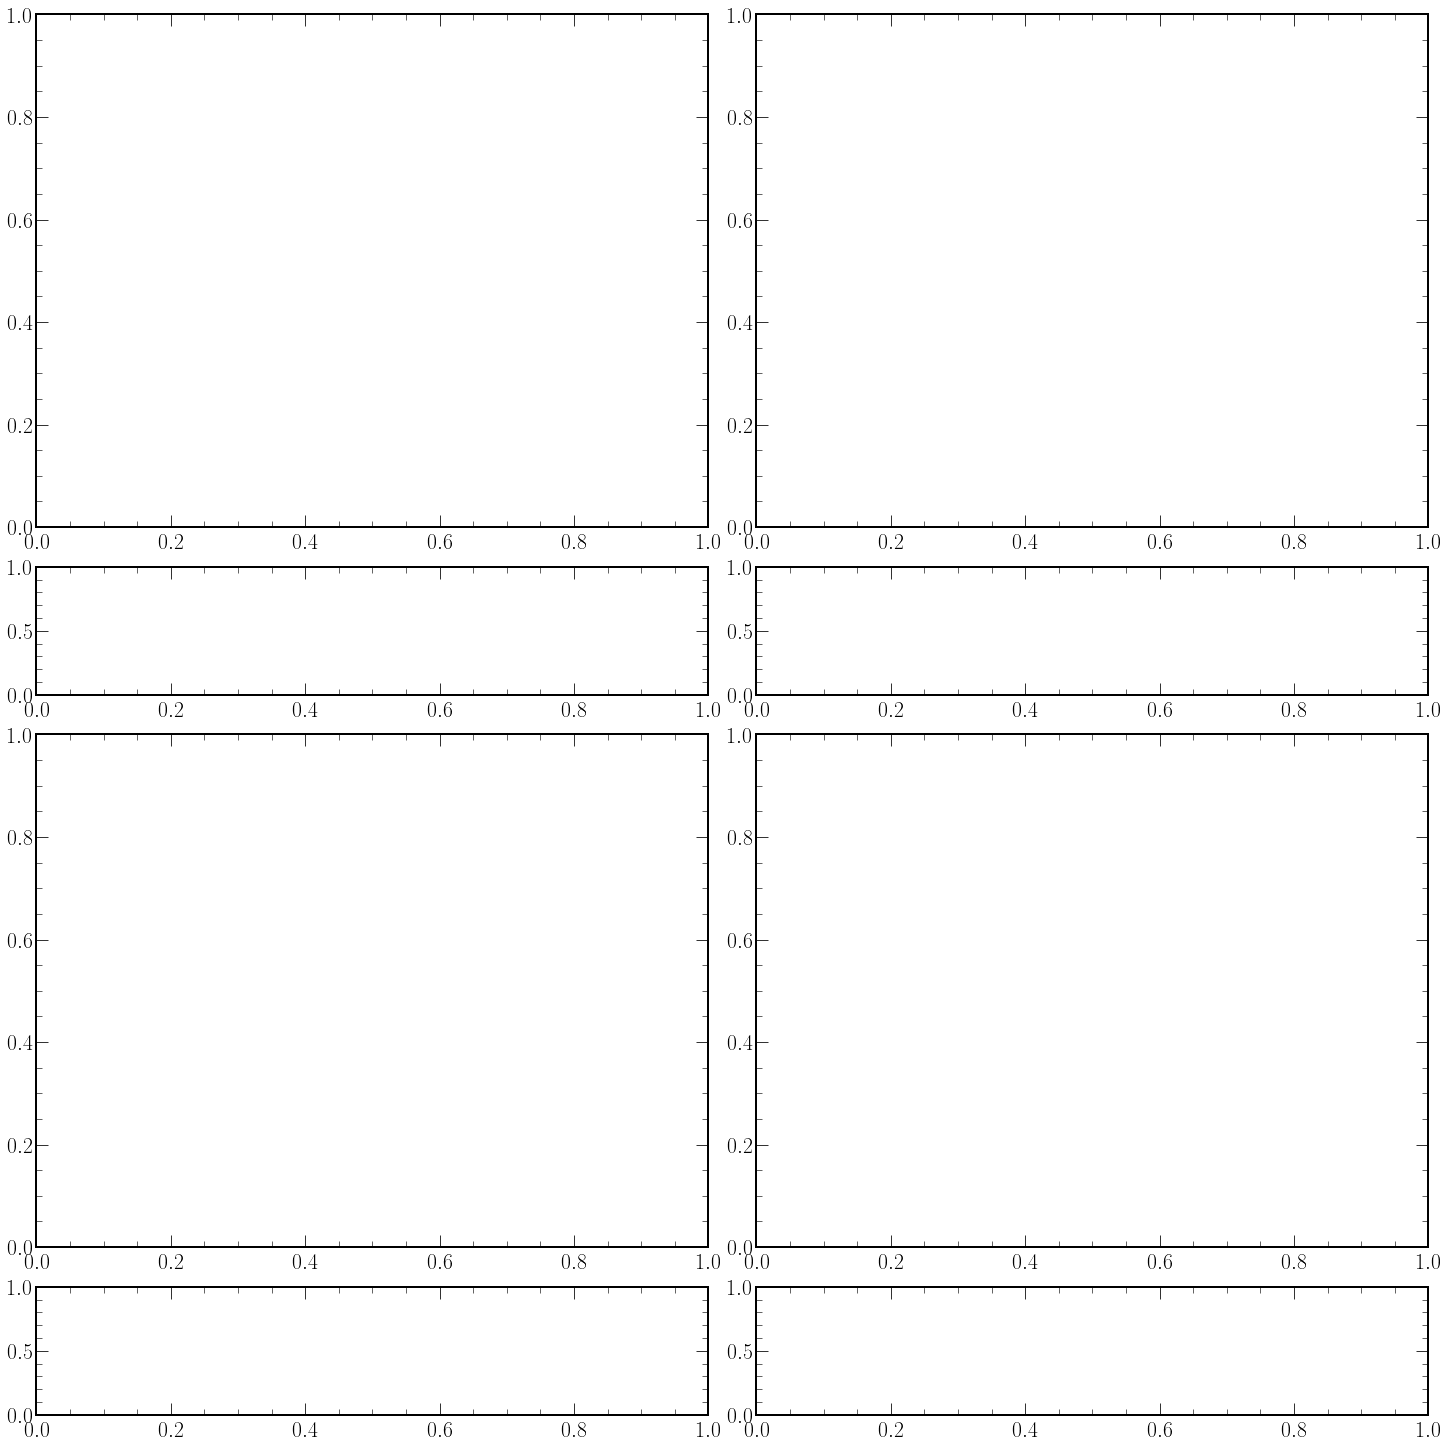

In [30]:
plot_sys(1)